In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from six.moves import urllib
from IPython.display import clear_output

In [2]:
import tensorflow as tf

In [3]:
train_path = tf.keras.utils.get_file('titanic_train.csv',
                                'https://storage.googleapis.com/tf-datasets/titanic/train.csv',
                                cache_dir='./')

eval_path = tf.keras.utils.get_file('titanic_eval.csv', 
                                    'https://storage.googleapis.com/tf-datasets/titanic/eval.csv',
                                    cache_dir='./')

In [4]:
dftrain = pd.read_csv(train_path)
dfeval = pd.read_csv(eval_path)

In [5]:
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [6]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [7]:
dfeval.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,35.0,0,0,8.0500,Third,unknown,Southampton,y
1,male,54.0,0,0,51.8625,First,E,Southampton,y
2,female,58.0,0,0,26.5500,First,C,Southampton,y
3,female,55.0,0,0,16.0000,Second,unknown,Southampton,y
4,male,34.0,0,0,13.0000,Second,D,Southampton,y


In [8]:
dftrain.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,627.0,29.631308,12.511818,0.75,23.0000,28.0000,35.0000,80.0000
n_siblings_spouses,627.0,0.545455,1.151090,0.00,0.0000,0.0000,1.0000,8.0000
parch,627.0,0.379585,0.792999,0.00,0.0000,0.0000,0.0000,5.0000
fare,627.0,34.385399,54.597730,0.00,7.8958,15.0458,31.3875,512.3292


In [9]:
dftrain.shape, dfeval.shape

((627, 9), (264, 9))

<AxesSubplot:>

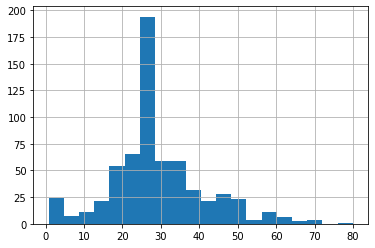

In [10]:
dftrain.age.hist(bins=20)

<AxesSubplot:>

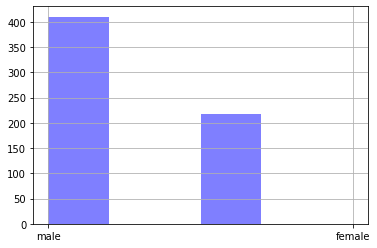

In [11]:
dftrain.sex.hist(color='blue', alpha=0.5, width=0.2, bins=2)

<AxesSubplot:>

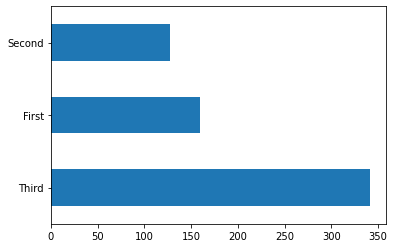

In [12]:
dftrain['class'].value_counts().plot(kind='barh')

In [13]:
pd.concat([dftrain, y_train], axis=1)

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone,survived
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n,0
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n,1
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y,1
3,female,35.0,1,0,53.1000,First,C,Southampton,n,1
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y,0
...,...,...,...,...,...,...,...,...,...,...
622,male,28.0,0,0,10.5000,Second,unknown,Southampton,y,0
623,male,25.0,0,0,7.0500,Third,unknown,Southampton,y,0
624,female,19.0,0,0,30.0000,First,B,Southampton,y,1
625,female,28.0,1,2,23.4500,Third,unknown,Southampton,n,0


Text(0.5, 0, '% survive')

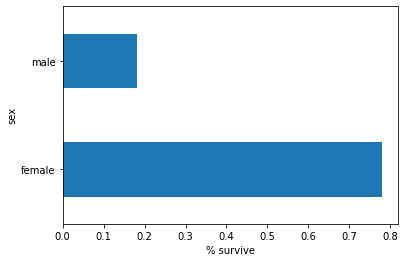

In [14]:
# 将目标列重新添加回 df
full_dftrain = pd.concat([dftrain, y_train], axis=1)
full_dftrain.groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

## Feature Engineering
确定哪些特征可能在训练模型方面非常有用，然后将日志文件及其他来源的原始数据转换为所需的特征。
feature columns:
* base feature columns from raw feature dict (原始特征)
* derived（派生、合成） feature columns from over one or multiple base columns （一般为组合特征 feature cross，笛卡尔积），特征组合有助于表达非线性关系。

### Base Feature Columns

In [15]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    # 列出每个分类的值
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [16]:
# 9 个基础特征列
len(feature_columns)

9

## Input Function (create dataset)

In [17]:
def make_input_fn(data_df, label_series, num_epochs=10, shuffle=True, batch_size=32):
    def input_fn():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_series))
        if shuffle:
            ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_fn

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

测试一下 input_function

In [18]:
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
    print('Some feature keys:', list(feature_batch.keys()))
    print()
    print('A batch of class:', feature_batch['class'].numpy())
    print()
    print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'Third' b'First' b'Third' b'First' b'Third' b'Third' b'Third' b'Second'
 b'Third' b'Third']

A batch of Labels: [0 1 1 1 0 0 1 1 1 0]


## Train Model with Estimator
我们已经设置好了 feature columns （base feature columns）
下面通过 estimator 训练

In [19]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
clear_output()

In [20]:
result = linear_est.evaluate(eval_input_fn)
clear_output()
print(result)

{'accuracy': 0.7613636, 'accuracy_baseline': 0.625, 'auc': 0.83419037, 'auc_precision_recall': 0.77589166, 'average_loss': 0.4760421, 'label/mean': 0.375, 'loss': 0.4658537, 'precision': 0.6875, 'prediction/mean': 0.35948163, 'recall': 0.6666667, 'global_step': 200}


In [21]:
pred_dicts = list(linear_est.predict(eval_input_fn))
clear_output()

### Derived Feature Columns
我们引入派生类的 feature columns，重新做特征工程。  
上面的训练结果看，我们的准确度在 75%。我们可以看出单独使用每个基本功能的列可能不足以解释数据。例如如果只仅针对“性别=“男性”和性别=“女性”学习单个模型权重，则不会捕获所有年龄-性别组合。  
为了学习不同特征组和对模型的影响，我们可以将 cross feature columns 添加到 model 上。
甚至，可以在 cross feature columns 之前，对 age 进行分桶。

In [22]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)

In [23]:
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)
clear_output()
print(result)

{'accuracy': 0.77272725, 'accuracy_baseline': 0.625, 'auc': 0.8409856, 'auc_precision_recall': 0.77201474, 'average_loss': 0.46964958, 'label/mean': 0.375, 'loss': 0.45842585, 'precision': 0.7010309, 'prediction/mean': 0.3598068, 'recall': 0.68686867, 'global_step': 200}


## predictions with model trained

In [24]:
pred_dicts = list(linear_est.predict(eval_input_fn))
clear_output()

<AxesSubplot:title={'center':'predicted probabilities'}, ylabel='Frequency'>

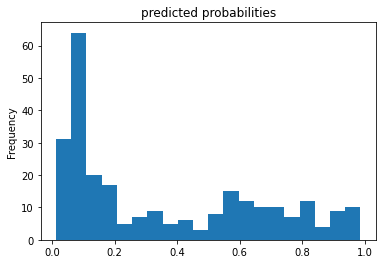

In [25]:
# 在测试集上统计能存活的概率分布
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
probs.plot(kind='hist', bins=20, title='predicted probabilities')

## 绘制二分类的 ROC 曲线

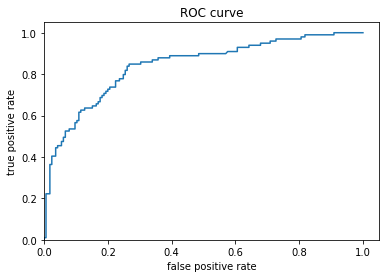

In [47]:
# threshold: probs 的概率值，作为划分二分类属于正分类的依据 
# 根据不同 threshhold （由大到小）计算出一组 （TPR, FPR）点绘制 ROC 曲线
# 理想目标：TPR=1，FPR=0，即图中(0,1)点，故 ROC 曲线越靠拢(0,1)点，越偏离45度对角线越好

from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

In [46]:
max(probs), min(probs)

(0.9865298271179199, 0.012343870475888252)

In [39]:
threshold

array([1.98652983, 0.98652983, 0.97878498, 0.861157  , 0.83193272,
       0.76973188, 0.76668507, 0.73471189, 0.72300839, 0.70320863,
       0.69713497, 0.69438434, 0.67544466, 0.66910541, 0.66610342,
       0.6618101 , 0.65685433, 0.64216995, 0.62224358, 0.61785293,
       0.61126757, 0.60657829, 0.60351175, 0.59887731, 0.59129447,
       0.59082347, 0.59070247, 0.5906834 , 0.59051782, 0.58971763,
       0.57886171, 0.5777325 , 0.55830914, 0.55540824, 0.53558743,
       0.52988684, 0.52498639, 0.52469271, 0.52334988, 0.50680035,
       0.46495509, 0.46271408, 0.45785543, 0.45060202, 0.44351646,
       0.43505993, 0.43474489, 0.43002796, 0.41257271, 0.39576122,
       0.369881  , 0.33377784, 0.32500494, 0.32059079, 0.31278402,
       0.30687305, 0.29345965, 0.28452134, 0.27838072, 0.26612511,
       0.25815895, 0.24753134, 0.20049214, 0.19906077, 0.19632006,
       0.19106276, 0.18635073, 0.18324831, 0.17007063, 0.16183119,
       0.14670344, 0.13658546, 0.11043995, 0.1100833 , 0.10211

## AUC
AUC (Area Under Curve) 被定义为ROC曲线下的面积，显然这个面积的数值不会大于1。又由于ROC曲线一般都处于y=x这条直线的上方，所以AUC的取值范围一般在0.5和1之间。使用AUC值作为评价标准是因为很多时候ROC曲线并不能清晰的说明哪个分类器的效果更好，而作为一个数值，对应AUC更大的分类器效果更好。

从AUC判断分类器（预测模型）优劣的标准：

* AUC = 1，是完美分类器，采用这个预测模型时，存在至少一个阈值能得出完美预测。绝大多数预测的场合，不存在完美分类器。
* 0.5 < AUC < 1，优于随机猜测。这个分类器（模型）妥善设定阈值的话，能有预测价值。
* AUC = 0.5，跟随机猜测一样（例：丢铜板），模型没有预测价值。
* AUC < 0.5，比随机猜测还差；但只要总是反预测而行，就优于随机猜测。

## 为什么使用ROC曲线
既然已经这么多评价标准，为什么还要使用ROC和AUC呢？
因为ROC曲线有个很好的特性：当测试集中的正负样本的分布变化的时候，ROC曲线能够保持不变。
在实际的数据集中经常会出现类不平衡(class imbalance)现象，即负样本比正样本多很多(或者相反)，
而且测试数据中的正负样本的分布也可能随着时间变化。